In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pyemma as pye
import glob
%matplotlib inline
import molpx 
%matplotlib ipympl
import matplotlib.pyplot as plt
%matplotlib ipympl
import matplotlib
import mdtraj
import nglview
matplotlib.__version__

ImportError: No module named pyemma

In [96]:
path=os.path.join('/Volumes/Vikas\'s Drive','Trajectories_processed','POPC')
traj_files = glob.glob(path + "/*.xtc") 
pdb_files = glob.glob(path + "/*.pdb")
pdb_files

["/Volumes/Vikas's Drive/Trajectories_processed/POPC/604-639.pdb",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC/backbone.pdb",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC/combined_backbone.pdb",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC/processed-trans.pdb"]

## Feature Selection

In [93]:
feature = pye.coordinates.featurizer(pdb_files[1])
feature.add_selection(feature.select_Backbone())
reader = pye.coordinates.source(traj_files[-2], features=feature)

## Dimensionality Reduction

In [11]:
pca_obj = pye.coordinates.pca(reader, dim=5)
Y =pca_obj.get_output()
np.save('pca-1-288-2.npy',Y)
Y_conc=np.concatenate(Y)


## Projection and validation of structures

In [12]:
cumulative_variance=pca_obj.cumvar
with open('cumvar.dat','w') as f:
    np.savetxt(f,cumulative_variance)

In [4]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,7))
plt.plot(cumulative_variance[0:10], marker='o', ms=20, markerfacecolor=diverging_colors[5])
plt.xticks( np.arange(0,10), size=20)
plt.ylabel('Fraction of Cumulative Kinetic variance', size=20, weight='bold')
plt.yticks(size=20)
plt.xlabel('PCA component', size=20, weight='bold')
plt.tight_layout()
plt.savefig('cumulative variance.png',dpi=300)

NameError: name 'cumulative_variance' is not defined

<Figure size 720x504 with 0 Axes>

In [112]:
pye.plots.plot_free_energy(*pca_obj[:,0:2].T)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a22aca438>)

## load saved pca object and data

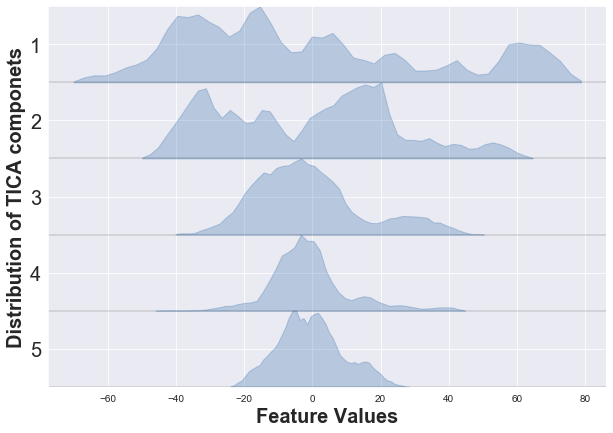

In [3]:
diverging_colors = sns.color_palette("RdBu", 10)
sns.set_style('darkgrid')
pca_obj=np.genfromtxt('PCA-backbone-dim-5.dat')
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
pye.plots.plot_feature_histograms(pca_obj, feature_labels=np.arange(1,6).tolist(), ax=axes,color=diverging_colors[9],)
#plt.xticks( np.arange(-90,90,20), size=20)
plt.ylabel('Distribution of TICA componets', size=20, weight='bold')
plt.yticks(size=20)
plt.xlabel( 'Feature Values',size=20, weight='bold')
plt.savefig('Feature-hist.png',dpi=300)

In [5]:
from sklearn.cluster import KMeans
convergence_kmeans=[]
for i in range(2,30):
    kmeans=KMeans(n_clusters=i, random_state=0).fit(pca_obj)
    convergence_kmeans.append(kmeans.inertia_)

In [4]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.plot(convergence_kmeans, marker='o',ms=15, lw=2, markerfacecolor=diverging_colors[5])
plt.xticks( np.arange(0,30,5), size=20)
plt.ylabel('Reduction in variation', size=20, weight='bold')
plt.yticks(size=20)
plt.xlabel('Number of clusters', size=20, weight='bold')

NameError: name 'convergence_kmeans' is not defined

<Figure size 720x432 with 0 Axes>

In [36]:
cluster = pye.coordinates.cluster_kmeans(pca_obj[:,0:2], k=300, max_iter=500)
dtrajs = cluster.dtrajs

In [53]:
lags = [1,10,25, 50, 100, 250 , 300, 400, 500,750, 1000,1200, 1500,1750, 2000]
its = pye.msm.its(dtrajs, lags=lags, errors='bayes')

## cluster_kmeans.dtrajs

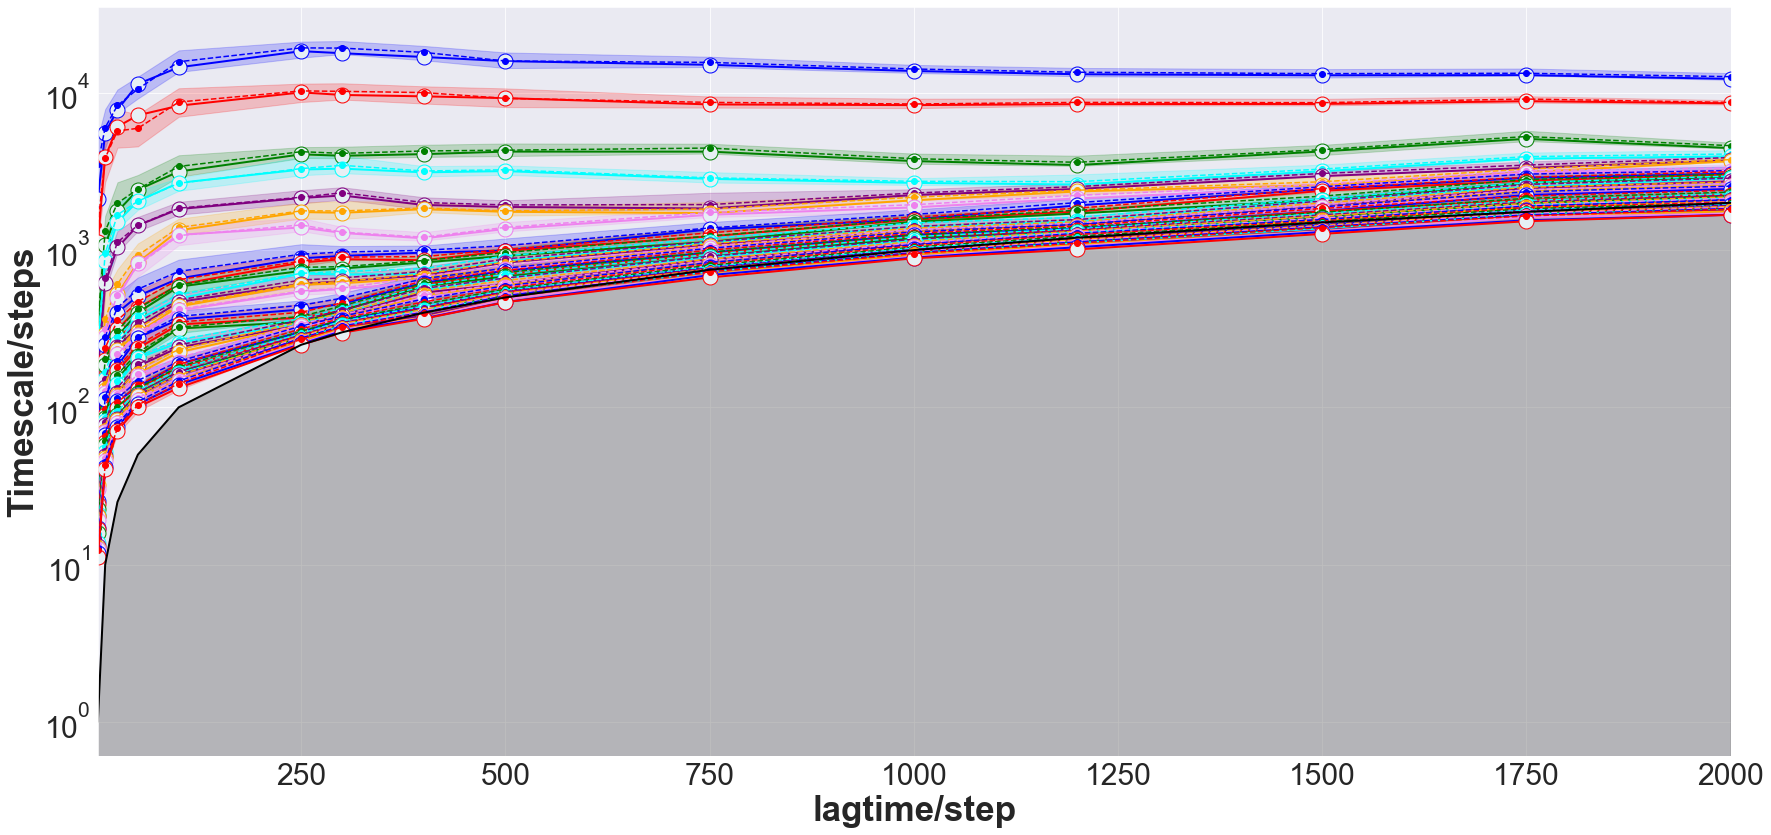

In [60]:
fig, axes = plt.subplots(figsize=(25,12))
pye.plots.plot_implied_timescales(its, marker='o', ms=15, lw=2, markerfacecolor=diverging_colors[5], nits=30 )

plt.xticks(size=30)
plt.xlabel('lagtime/step', size=35, weight='bold')
plt.yticks(size=30)
plt.ylabel('Timescale/steps', size=35, weight='bold')
plt.tight_layout()
plt.savefig('itsplot.png',dpi=300)

## MSM estimation

In [113]:
M = pye.msm.estimate_hidden_markov_model(dtrajs,lag=500,nstates=2)

In [102]:
len(dtrajs[0])

38912

In [83]:
print('fraction of states used = {:f}'.format(M.active_state_fraction))
print('fraction of counts used = {:f}'.format(M.active_count_fraction))

AttributeError: 'MaximumLikelihoodHMSM' object has no attribute 'active_state_fraction'

(-0.5, 10.5)

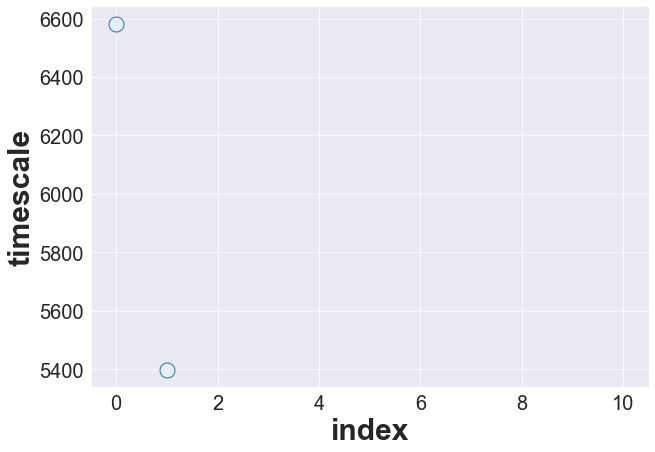

In [84]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(M.timescales(),linewidth=0,marker='o',ms=15,markerfacecolor=diverging_colors[5])
plt.xlabel('index', size=30,weight='bold')
plt.ylabel('timescale', size=30, weight='bold')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(-0.5,10.5)

(-0.5, 10.5)

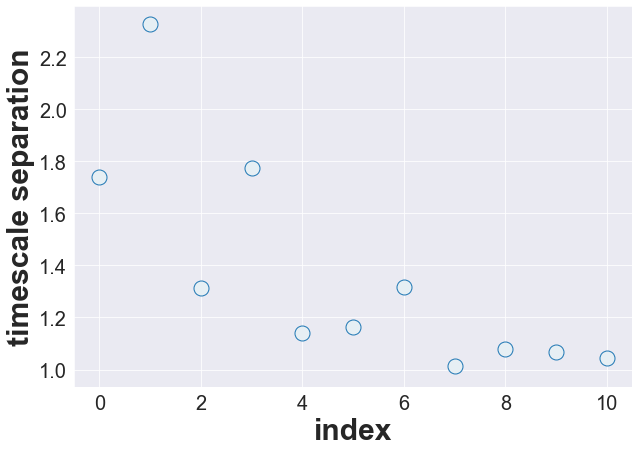

In [76]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(M.timescales()[:-1]/M.timescales()[1:],linewidth=0,marker='o',ms=15,markerfacecolor=diverging_colors[5])
plt.xlabel('index', size=30,weight='bold')
plt.ylabel('timescale separation', size=30, weight='bold')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(-0.5,10.5)

In [114]:
sns.set_style('darkgrid')
n_sets = 2
ck = M.cktest(n_sets
              , err_est=True, show_progress=True)

plt.rcParams.update({'font.size': 20})
pye.plots.plot_cktest(ck, diag=False, figsize=(10,10), layout=(n_sets, n_sets), padding_top=0.1, dt=0.04, y01=False, padding_between=0.3,  units='ns')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 720x720 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21f96e48>,
       dtype=object))

In [129]:
pye.plots.plot_free_energy(*pca_obj[:,0:2].T)
#plt.scatter(x=pca_obj[:,0],y=pca_obj[:,1],c=M.hidden_state_trajectories)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2eaa8710>)

In [49]:
for i, s in enumerate(M.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, M.pi[s].sum()))

IndexError: index 3 is out of bounds for axis 0 with size 3

In [119]:
hmm = M.coarse_grain(2)

AttributeError: 'MaximumLikelihoodHMSM' object has no attribute 'coarse_grain'

In [165]:
M.stationary_distribution

array([0.2132, 0.3104, 0.4764])

In [166]:
np.set_printoptions(precision=4, suppress=True)
print(M.transition_matrix)

[[0.9239 0.023  0.0531]
 [0.0158 0.9602 0.0241]
 [0.0238 0.0157 0.9605]]


In [167]:
trans_mat=M.transition_matrix
trans_mat=trans_mat*100/3
trans_mat1=trans_mat
np.fill_diagonal(trans_mat1,0)
trans_mat=(trans_mat/trans_mat1.sum())*100
trans_mat

array([[ 0.    , 14.7753, 34.1857],
       [10.149 ,  0.    , 15.4972],
       [15.2971, 10.0956,  0.    ]])

In [168]:
pos=np.array([[0,0.29],[0.49,0],[1.01,0.28]])
pos=np.array([[0.55    , 1. ],
        [0.9992, 0.0],
    [0.1304, 0.    ]])
states=['State2','State1','State3']
pye.plots.plot_markov_model(M,state_scale=1.2,pos=pos, max_height=15, arrow_scale=1.5, arrow_curvature=2, state_labels=states, max_width=10, arrow_labels=trans_mat, arrow_label_format='%0.1f',state_colors=[diverging_colors[2],diverging_colors[4],diverging_colors[7]])
#pye.plots.plot_markov_model(hmm)

/anaconda2/envs/py36/lib/python3.6/site-packages/pyemma/plots/networks.py:188: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = _plt.figure(None, figsize=figsize)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 720x828.729 with 1 Axes>, array([[0.55  , 1.    ],
        [0.9992, 0.    ],
        [0.1304, 0.    ]]))

In [123]:
nstates=3
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = M.mfpt(
            M.metastable_sets[i],
            M.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
MPT=DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))
MPT=MPT*40

AssertionError: Chosen set contains states that are not included in the active set.

In [70]:
plt.figure(figsize=(10,7))
plt.tight_layout()
sns.heatmap(data=MPT,lw=2, annot=True)


/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [71]:
hmm.stationary_distribution

array([0.2465, 0.1809, 0.5726])

In [79]:
pye.plots.plot_cktest(hmm.cktest(mlags=5, err_est=True), diag=True, figsize=(10,10), layout=(n_sets, n_sets), padding_top=0.1, y01=False, padding_between=0.3, dt=0.01, units='ns')


/anaconda2/envs/py36/lib/python3.6/site-packages/pyemma/plots/markovtests.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(layout[0], layout[1], sharex=True, sharey=sharey, figsize=figsize)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(<Figure size 720x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4d5644a8>,
       dtype=object))

In [174]:
metastable_traj = M.metastable_assignments[dtrajs]
highest_membership = M.metastable_distributions.argmax(1)
highest_membership_value = M.metastable_distributions.max(1)
coarse_state_centers = cluster.clustercenters[M.active_set[highest_membership]]

/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [170]:
M.

array([array([0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
       array([0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
       array([0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
       array([0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [104]:
pcca_samples = M.sample_by_observation_probabilities(nsample=100)

In [ ]:
pcca_samples = M.sample_by_observation_probabilities

In [ ]:
pcca_samples = M.sample_by_observation_probabilities

In [68]:
M.s

array([[1.70025802e-235, 6.95652953e-075, 6.27363950e-003,
        1.15870281e-002, 5.63347220e-003, 2.04575253e-244,
        6.33765623e-003, 8.51422503e-003, 4.30204283e-143,
        9.28242579e-003, 1.19212819e-245, 2.09608025e-251,
        4.73723799e-003, 6.18758210e-005, 2.94476956e-003,
        5.63606126e-240, 1.66336475e-188, 8.00209120e-003,
        2.26649554e-201, 5.78025254e-004, 1.04987437e-002,
        9.02635887e-003, 3.84100377e-003, 1.17582134e-245,
        3.64355943e-051, 6.34322868e-281, 4.41715434e-003,
        1.12669444e-002, 3.00878629e-003, 1.38916303e-002,
        9.61131154e-064, 7.42594063e-003, 4.22510415e-003,
        2.17794794e-281, 6.61286029e-244, 1.61018010e-189,
        6.78577334e-003, 9.28242579e-003, 5.95354120e-003,
        6.01757258e-003, 5.19068854e-242, 2.36861899e-003,
        7.93807447e-003, 5.50543874e-003, 7.29790717e-003,
        6.65773988e-003, 1.18261266e-244, 3.71297032e-003,
        1.82451413e-245, 1.98503337e-210, 3.86255442e-27

In [105]:
outfiles = []
for k in range(0, 2):
    intstring = str(k+1)
    filename = 'samples_HMM'+ intstring + '.xtc'
    outfiles.append(filename)

pye.coordinates.save_trajs(reader, pcca_samples, outfiles = outfiles)

['samples_HMM1.xtc', 'samples_HMM2.xtc']

In [99]:
!ls

Feature-hist.png         cumulative variance.png  samples_HMM2.xtc
MSM-PCA-POPC.ipynb       cumvar.dat               samples_HMM3.xtc
PCA-backbone-dim-3.dat   feature_histogram.png    samples_pcca1.xtc
PCA-backbone-dim-5.dat   itsplot.png              samples_pcca2.xtc
PCA-backbone-dim-7.dat   pca-1-288-2.npy          samples_pcca3.xtc
TNSE-PCA-2D.png          pca-tsne-DIM-2000-2D.dat
TNSE-hist.png            samples_HMM1.xtc


In [100]:
vis_set = 1
traj_sample = mdtraj.load_xtc('samples_HMM'+ str(vis_set) + '.xtc', top=pdb_files[2], stride = 1)
w = nglview.show_mdtraj(traj_sample)
w.clear_representations()
w.add_representation('tube', selection='backbone', color_scheme = 'hydrophobicity')
w

IndexError: index 0 is out of bounds for axis 0 with size 0